# Backtest Playground

`Run -> Run All Cells` だけで、データ取得・バックテスト・JSON保存・可視化まで実行します。

In [18]:
from pathlib import Path
import os
import sys

CANDIDATE_ROOTS = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/Users/umegakigen/gitProjects/crypto_trade_bot'),
]

ROOT = None
for candidate in CANDIDATE_ROOTS:
    if (candidate / 'pybot').exists() and (candidate / 'research').exists():
        ROOT = candidate
        break

if ROOT is None:
    raise RuntimeError('project root not found')

os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)


ROOT = /Users/umegakigen/gitProjects/crypto_trade_bot


In [19]:
# Parameters
PAIR = 'SOL/USDC'
TIMEFRAME = '2h'  # '2h' or '4h'
YEARS_OF_DATA = 2
BARS_PER_DAY_BY_TIMEFRAME = {'2h': 12, '4h': 6}
if TIMEFRAME not in BARS_PER_DAY_BY_TIMEFRAME:
    raise ValueError(f'unsupported timeframe: {TIMEFRAME}')
LIMIT = YEARS_OF_DATA * 365 * BARS_PER_DAY_BY_TIMEFRAME[TIMEFRAME]
REFRESH_DATA = False

USE_FIRESTORE_CURRENT_CONFIG = True
LIVE_CONFIG_PATH = ROOT / 'research/config.live.current.json'
DEFAULT_CONFIG_PATH = ROOT / 'research/config.json'
CONFIG_PATH = LIVE_CONFIG_PATH if USE_FIRESTORE_CURRENT_CONFIG else DEFAULT_CONFIG_PATH

CSV_PATH = ROOT / (f'research/data/raw/solusdc_{TIMEFRAME}_live.csv' if USE_FIRESTORE_CURRENT_CONFIG else f'research/data/raw/solusdc_{TIMEFRAME}.csv')
OUTPUT_PATH = ROOT / ('research/data/processed/backtest_live_config.json' if USE_FIRESTORE_CURRENT_CONFIG else 'research/data/processed/backtest_latest.json')

print('USE_FIRESTORE_CURRENT_CONFIG =', USE_FIRESTORE_CURRENT_CONFIG)
print('LIMIT =', LIMIT, f'(about {YEARS_OF_DATA} years)')
print('CONFIG_PATH =', CONFIG_PATH)
print('CSV_PATH =', CSV_PATH)
print('OUTPUT_PATH =', OUTPUT_PATH)


USE_FIRESTORE_CURRENT_CONFIG = True
LIMIT = 8760 (about 2 years)
CONFIG_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/config.live.current.json
CSV_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv
OUTPUT_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_live_config.json


In [20]:
import importlib.util
import subprocess

if importlib.util.find_spec('matplotlib') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])

import json
from collections import Counter

import matplotlib.pyplot as plt

from pybot.adapters.market_data.ohlcv_provider import OhlcvProvider
from research.src.adapters.csv_bar_repository import write_bars_to_csv, read_bars_from_csv, write_json
from research.src.infra.research_config import load_bot_config
from research.src.domain.backtest_engine import run_backtest


In [21]:
# FETCH_FIRESTORE_CURRENT_CONFIG
from dotenv import load_dotenv

if USE_FIRESTORE_CURRENT_CONFIG:
    from google.cloud import firestore

    load_dotenv(ROOT / '.env')
    credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    if not credentials_path:
        raise RuntimeError('GOOGLE_APPLICATION_CREDENTIALS is not set')

    credentials_file = Path(credentials_path)
    if not credentials_file.is_absolute():
        credentials_file = (ROOT / credentials_file).resolve()
    if not credentials_file.exists():
        raise RuntimeError(f'credential file not found: {credentials_file}')

    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(credentials_file)

    db = firestore.Client()
    doc = db.collection('config').document('current').get()
    if not doc.exists:
        raise RuntimeError('Firestore config/current does not exist')

    config_current = doc.to_dict()
    LIVE_CONFIG_PATH.parent.mkdir(parents=True, exist_ok=True)
    with LIVE_CONFIG_PATH.open('w', encoding='utf-8') as f:
        json.dump(config_current, f, ensure_ascii=False, indent=2)

    print(f'[synced] Firestore config/current -> {LIVE_CONFIG_PATH}')
else:
    print('[skip] using local config file only')


[synced] Firestore config/current -> /Users/umegakigen/gitProjects/crypto_trade_bot/research/config.live.current.json


In [22]:
provider = OhlcvProvider()

def fetch_or_backfill(limit: int):
    if limit <= 1000:
        return provider.fetch_bars(pair=PAIR, timeframe=TIMEFRAME, limit=limit)
    return provider.fetch_bars_backfill(pair=PAIR, timeframe=TIMEFRAME, total_limit=limit)

if REFRESH_DATA or not CSV_PATH.exists():
    bars_fetched = fetch_or_backfill(LIMIT)
    write_bars_to_csv(CSV_PATH, bars_fetched)
    print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
else:
    bars_cached = read_bars_from_csv(CSV_PATH)
    if len(bars_cached) < LIMIT:
        print(f'[cache-insufficient] {len(bars_cached)} < {LIMIT}, refetching...')
        bars_fetched = fetch_or_backfill(LIMIT)
        write_bars_to_csv(CSV_PATH, bars_fetched)
        print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
    else:
        print(f'[cached] using existing file: {CSV_PATH} ({len(bars_cached)} bars)')


[cached] using existing file: /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv


In [23]:
config = load_bot_config(CONFIG_PATH)
bars = read_bars_from_csv(CSV_PATH)
report = run_backtest(bars, config)
write_json(OUTPUT_PATH, report.to_dict())

with OUTPUT_PATH.open('r', encoding='utf-8') as f:
    report_json = json.load(f)

print('[saved]', OUTPUT_PATH)
report_json['summary']


[saved] /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_live_config.json


{'total_bars': 1000,
 'decision_enter_count': 16,
 'decision_no_signal_count': 759,
 'closed_trades': 16,
 'open_trades': 0,
 'wins': 8,
 'losses': 8,
 'win_rate_pct': 50.0,
 'average_pnl_pct': -0.071857,
 'total_pnl_pct': -1.149711,
 'average_r_multiple': 0.0,
 'first_bar_close_time': '2025-11-30T06:00:00Z',
 'last_bar_close_time': '2026-02-21T12:00:00Z'}

In [24]:
top_reasons = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)
trades_preview = report_json['trades'][:5]
{
    'top_no_signal_reasons': top_reasons[:10],
    'trades_preview': trades_preview,
}


{'top_no_signal_reasons': [('EMA_TREND_FILTER_FAILED', 484),
  ('ATR_STOP_CONFLICT_MAX_LOSS', 139),
  ('RECLAIM_NOT_FOUND', 67),
  ('CHASE_ENTRY_TOO_FAR_FROM_EMA', 34),
  ('RSI_TOO_HIGH', 15),
  ('PULLBACK_NOT_FOUND', 6),
  ('INSUFFICIENT_BARS_1_OF_15', 1),
  ('INSUFFICIENT_BARS_2_OF_15', 1),
  ('INSUFFICIENT_BARS_3_OF_15', 1),
  ('INSUFFICIENT_BARS_4_OF_15', 1)],
 'trades_preview': [{'entry_time': '2025-12-08T08:00:00Z',
   'exit_time': '2025-12-09T16:00:00Z',
   'entry_price': 135.88,
   'stop_price': 131.8036,
   'take_profit_price': 139.9564,
   'exit_price': 131.8036,
   'exit_reason': 'STOP_LOSS',
   'pnl_pct': -3.0,
   'r_multiple': -1.0,
   'holding_bars': 16},
  {'entry_time': '2025-12-15T08:00:00Z',
   'exit_time': '2025-12-15T16:00:00Z',
   'entry_price': 132.36,
   'stop_price': 128.3892,
   'take_profit_price': 136.3308,
   'exit_price': 128.3892,
   'exit_reason': 'STOP_LOSS',
   'pnl_pct': -3.0,
   'r_multiple': -1.0,
   'holding_bars': 4},
  {'entry_time': '2025-12-25T1

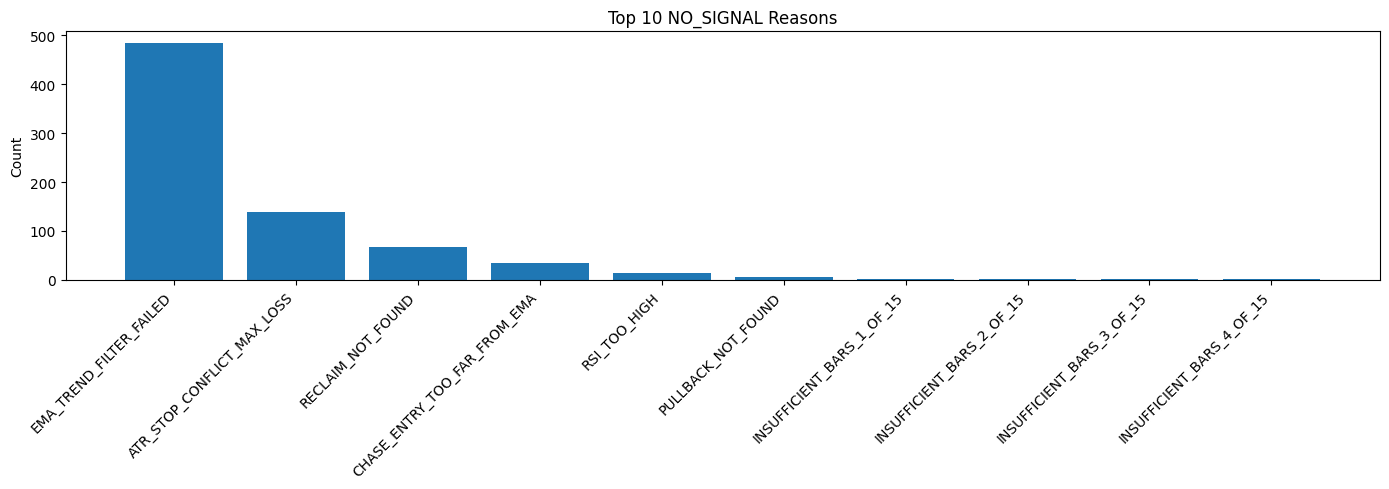

In [25]:
reason_items = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)[:10]

labels = [item[0] for item in reason_items]
values = [item[1] for item in reason_items]

plt.figure(figsize=(14, 5))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.title('Top 10 NO_SIGNAL Reasons')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


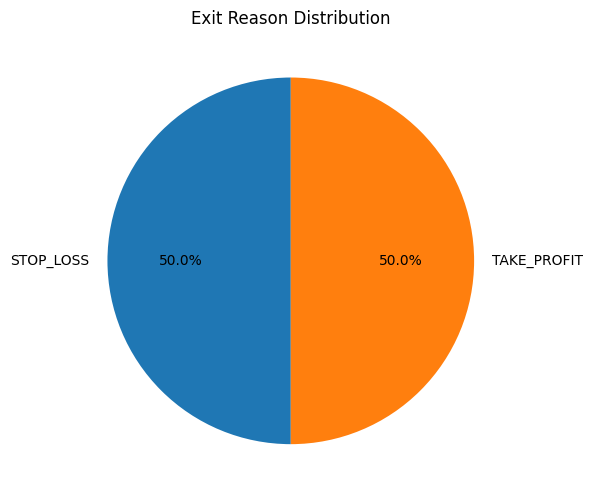

In [26]:
closed_trades = [t for t in report_json['trades'] if t.get('exit_reason') != 'OPEN']

if not closed_trades:
    print('No closed trades yet. Exit reason chart skipped.')
else:
    exit_counts = Counter(t.get('exit_reason', 'UNKNOWN') for t in closed_trades)
    labels = list(exit_counts.keys())
    values = [exit_counts[k] for k in labels]

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Exit Reason Distribution')
    plt.tight_layout()
    plt.show()


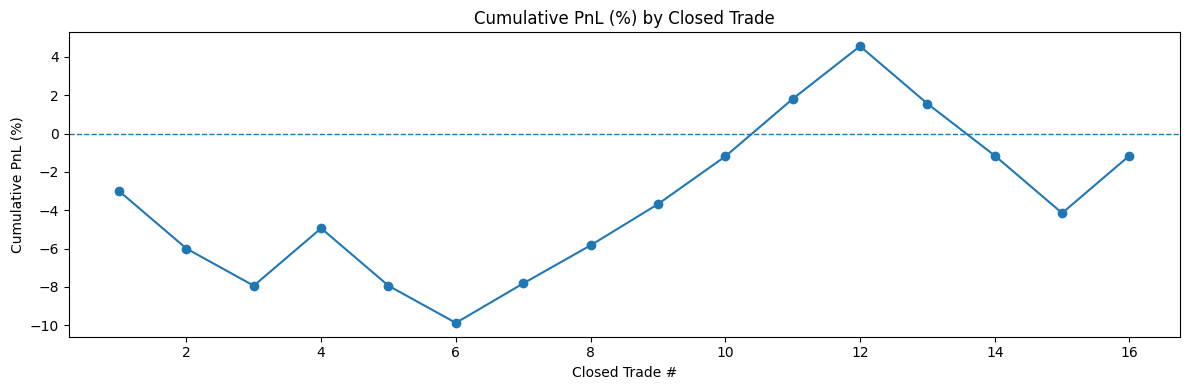

In [27]:
pnl_pct_values = [t.get('pnl_pct') for t in closed_trades if t.get('pnl_pct') is not None]

if not pnl_pct_values:
    print('No closed trades yet. Equity curve skipped.')
else:
    cumulative = []
    running = 0.0
    for value in pnl_pct_values:
        running += float(value)
        cumulative.append(running)

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title('Cumulative PnL (%) by Closed Trade')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Cumulative PnL (%)')
    plt.tight_layout()
    plt.show()


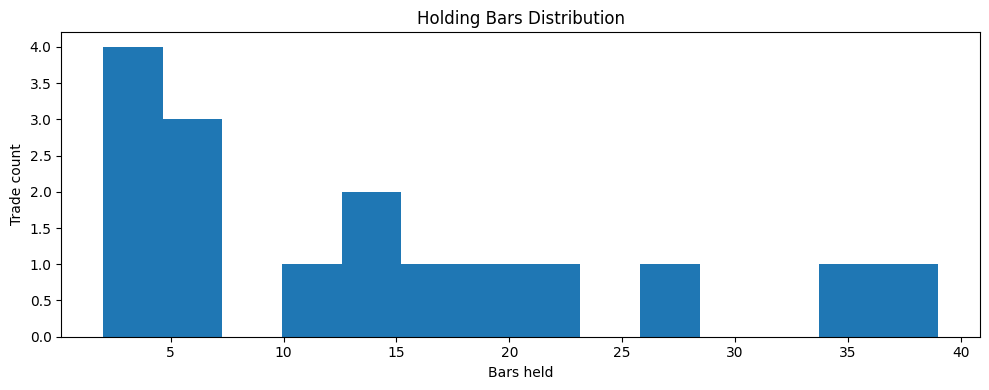

In [28]:
holding_bars = [t.get('holding_bars') for t in closed_trades if t.get('holding_bars') is not None]

if not holding_bars:
    print('No closed trades yet. Holding bars histogram skipped.')
else:
    unique_count = len(set(holding_bars))
    bins = min(max(unique_count, 5), 20)

    plt.figure(figsize=(10, 4))
    plt.hist(holding_bars, bins=bins)
    plt.title('Holding Bars Distribution')
    plt.xlabel('Bars held')
    plt.ylabel('Trade count')
    plt.tight_layout()
    plt.show()
